In [16]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import librosa as lib
import os
from IPython.display import Audio
import random
from scipy.signal import iirfilter, sosfreqz, sosfilt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        os.path.join(dirname, filename)
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [17]:
def merge_audios(audio_files):
    audios = [lib.load(file, sr=None)[0] for file in audio_files]
    return np.concatenate(audios)

def plot_audio(y, sr, title=""):
    plt.figure(figsize=(25, 6)) 
    
    # Waveform
    plt.subplot(1, 3, 1)
    lib.display.waveshow(y, sr=sr)
    plt.title('Waveform - ' + title)
    
    # Spectrogram
    plt.subplot(1, 3, 2)
    D = lib.amplitude_to_db(np.abs(lib.stft(y)), ref=np.max)
    lib.display.specshow(D, sr=sr, x_axis='time', y_axis='log')
    plt.colorbar(label='dB')
    plt.title('Spectrogram - ' + title)
    
    # MFCC spectogram
    plt.subplot(1, 3, 3)
    M = lib.feature.mfcc(y=y, sr=sr)
    lib.display.specshow(M, sr=sr, x_axis='time')
    plt.colorbar()
    plt.title('MFCC - ' + title)
    plt.tight_layout()
    plt.show()

    

base_path = "/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches"
speakers = ["Benjamin_Netanyau", "Jens_Stoltenberg", "Julia_Gillard", "Magaret_Tarcher", "Nelson_Mandela"]




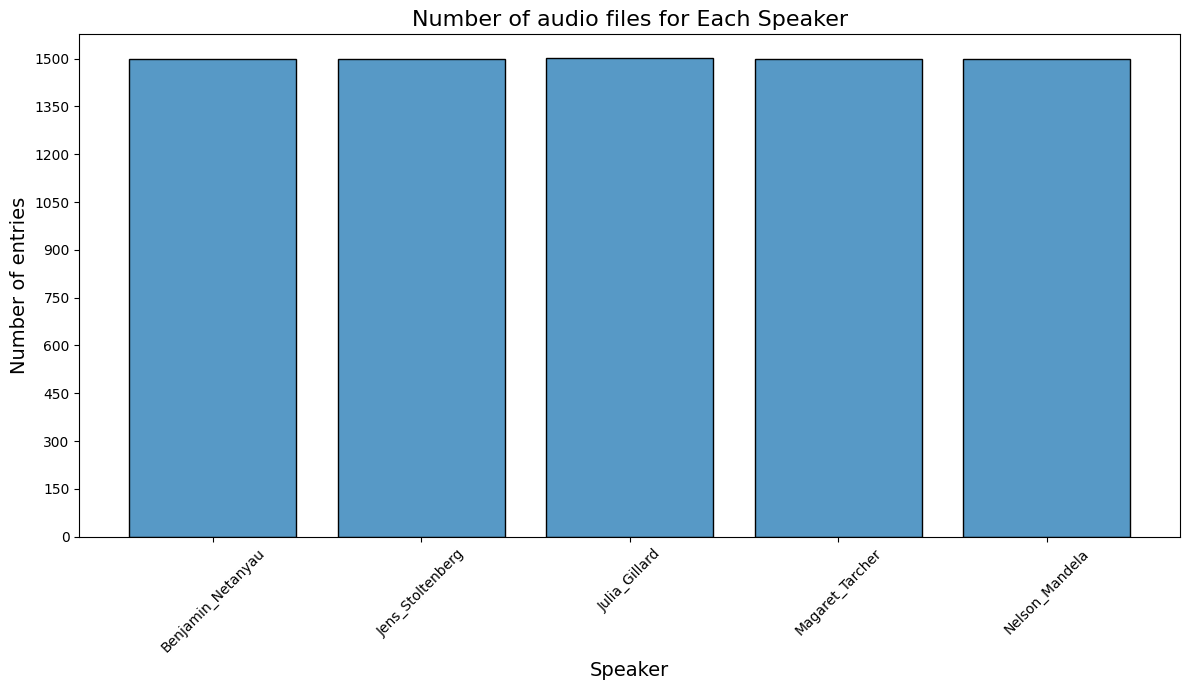

In [18]:
data_raw = []

for speaker in speakers:
    speaker_path = os.path.join(base_path, speaker)
    audio_files = [os.path.join(speaker_path, f) for f in sorted(os.listdir(speaker_path))]
    
    for file in audio_files:
        y, sr = lib.load(file, sr=None)
        
        # Extracting MFCCs for each audio file
        mfcc_raw = lib.feature.mfcc(y=y, sr=sr, n_mfcc=20)
        mean_mfcc_raw = mfcc_raw.mean(axis=1)
        data_raw.append([*mean_mfcc_raw, speaker])

# Creating a DataFrame
df_raw = pd.DataFrame(data_raw, columns=[f"MFCC_{i+1}" for i in range(20)] + ['Speaker'])

plt.figure(figsize=(12, 7))
sns.histplot(df_raw['Speaker'], discrete=True, kde=False, shrink=0.8)
plt.title('Number of audio files for Each Speaker', fontsize=16)
plt.xlabel('Speaker', fontsize=14)
plt.ylabel('Number of entries', fontsize=14)
plt.xticks(rotation=45)
plt.yticks(list(i for i in range(0,1501,150)))
plt.tight_layout()
plt.show()




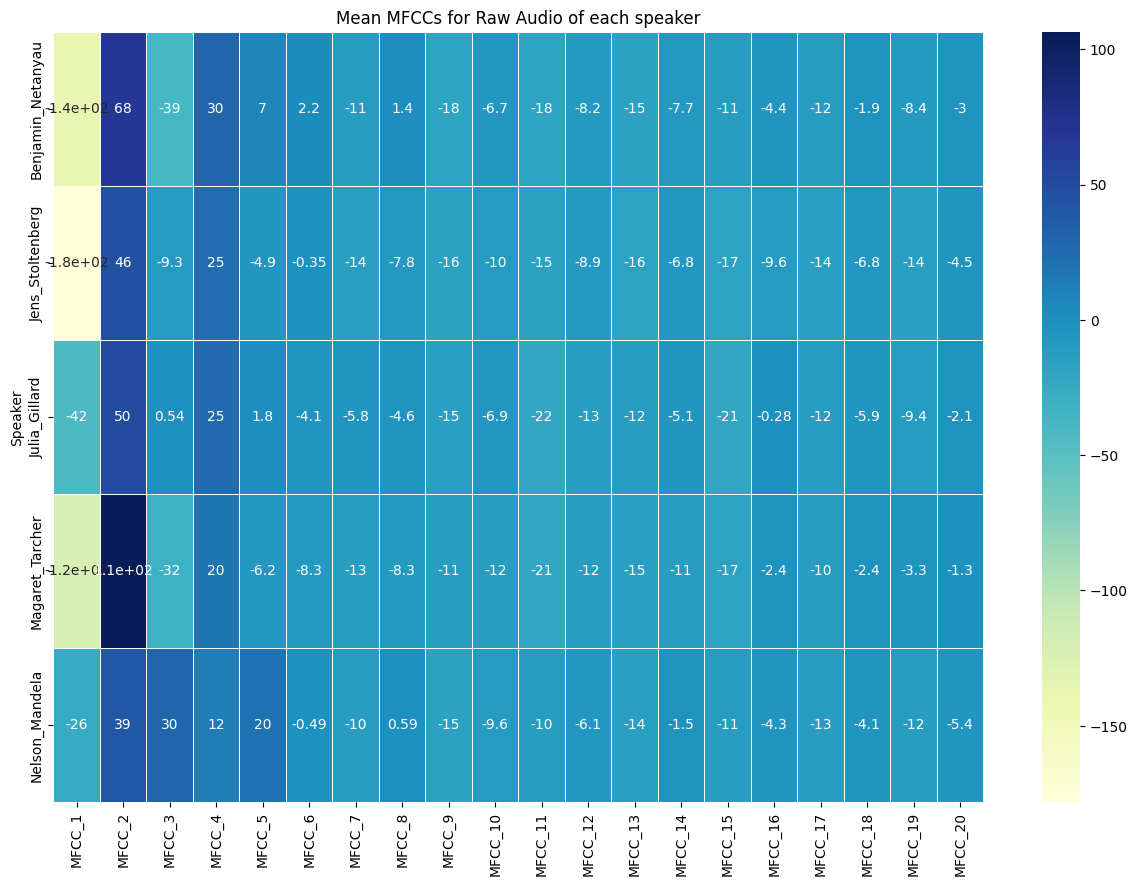

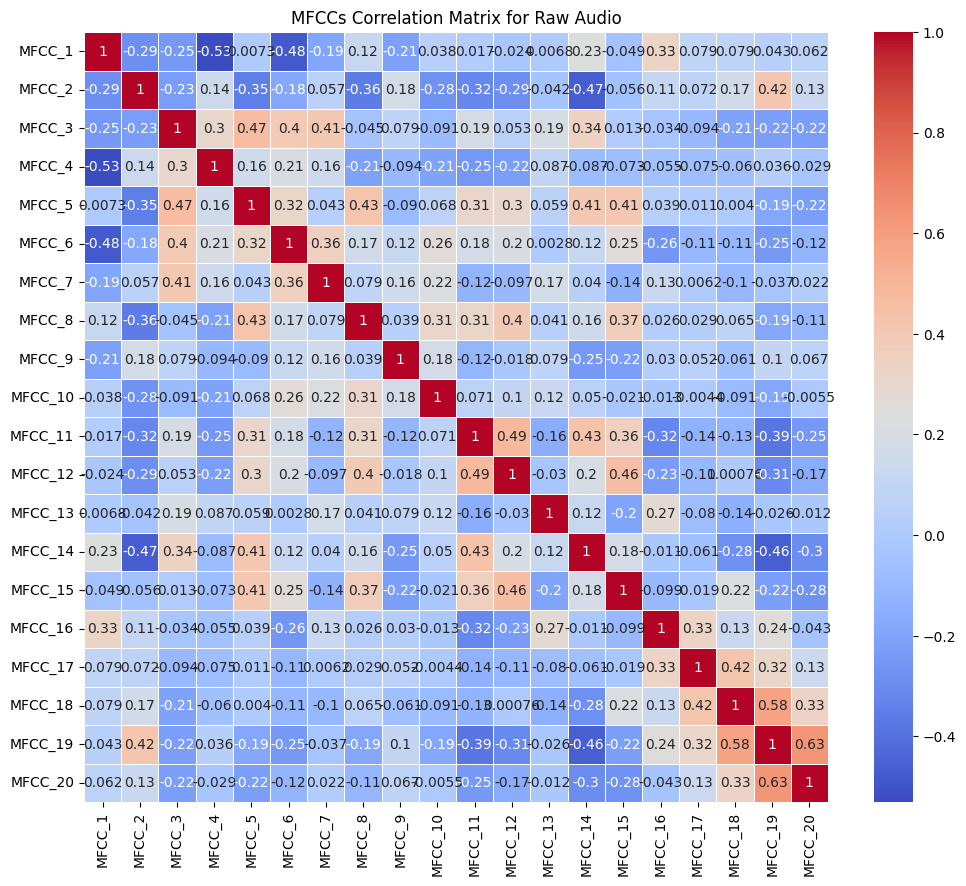

In [19]:
# Displaying the Mean MFCCs heatmap
mean_mfccs_raw = df_raw.groupby('Speaker').mean()
plt.figure(figsize=(15, 10))
sns.heatmap(mean_mfccs_raw, annot=True, cmap="YlGnBu", linewidths=.5)
plt.title("Mean MFCCs for Raw Audio of each speaker")
plt.show()

# Correlation Matrix for Raw Audio MFCCs
plt.figure(figsize=(12, 10))
sns.heatmap(df_raw.iloc[:, :-1].corr(), annot=True, cmap="coolwarm", linewidths=.5)
plt.title("MFCCs Correlation Matrix for Raw Audio")
plt.show()

In [20]:
noise_path= "/kaggle/input/speaker-recognition-dataset/16000_pcm_speeches/_background_noise_"  # Update with the actual path
noise_files = [os.path.join(noise_path, f) for f in os.listdir(noise_path)]

def add_random_bg_noise(y, sr):  # it will add background noises at random intervals
    y_noised = np.copy(y)
    
    # Randomly choose how many noise files to blend
    num_noises = random.randint(1, 4)

    for _ in range(num_noises):
        # Randomly select a noise file
        random_noise_path = random.choice(noise_files)
        
        # Determine random duration 
        random_duration = random.uniform(0.1, float(lib.get_duration(y=y_noised, sr=sr)))
        
        y_noise, sr_noise = lib.load(random_noise_path, sr=sr, duration=random_duration)  

        # Randomly select the starting point for the noise
        start_point= random.randint(0, len(y_noised) - len(y_noise))
        
        # Add the noise into the main audio at the randomly selected start sample
        y_noised[start_sample: start_sample + len(y_noise)] += y_noise[:min(len(y_noised) - start_sample, len(y_noise))]

    return y_noised, sr


def add_continous_bg_noise(y, sr):
    y_noised = np.copy(y)
    
    noise_signal = np.zeros_like(y)  # Initial empty noise signal of same length as audio
    
    for _ in range(len(y) // len(y_noise) + 1):  # Loop to ensure the noise covers the entire audio
        # Randomly select a noise file
        random_noise_path = random.choice(noise_files)
        
        # Load the noise signal
        y_noise, _ = lib.load(random_noise_path, sr=sr, duration=lib.get_duration(y=y, sr=sr))
        
        # Overlay the noise signal with the main audio signal
        start_idx = _ * len(y_noise)
        end_idx = start_idx + len(y_noise)
        noise_signal[start_idx:end_idx] += y_noise[:min(len(y_noised) - start_idx, len(y_noise))]
    
    # Combine the original audio and the noise
    y_noised += noise_signal
    
    # Ensure that the signal amplitude remains between -1 and 1
    y_noised = np.clip(y_noised, -1, 1)
    
    return y_noised, sr

def add_continous_bg_noise(y, sr):
    random_noise_path = random.choice(noise_files)
    y_noise, _ = lib.load(random_noise_path, sr=sr)
    
    # Repeat the noise until it's longer than the main audio
    num_repeats = -(-len(y) // len(y_noise)) 
    extended_noise = np.tile(y_noise, num_repeats)[:len(y)]  
    
    # Combine the audio with the noise
    y_noised = y + extended_noise
    y_noised = np.clip(y_noised, -1, 1)  # Ensure amplitude between -1 and 1
    
    return y_noised, sr


for speaker in speakers:
    speaker_path = os.path.join(base_path, speaker)
    audio_files = [os.path.join(speaker_path, f) for f in sorted(os.listdir(speaker_path))]
    
    print(speaker)    
    print("raw")
    y, sr = merge_audios(audio_files[30:40]), 16000
    display(Audio(y, rate=sr))
#     plot_audio(y, sr, title="Raw Audio")
    print("noised")
#     y_n,sr=add_random_bg_noise(y,sr)
    y,sr=add_continous_bg_noise(y,sr)

    display(Audio(y, rate=sr))
#     plot_audio(y_n, sr, title="noised Audio")


Benjamin_Netanyau
raw


noised


Jens_Stoltenberg
raw


noised


Julia_Gillard
raw


noised


Magaret_Tarcher
raw


noised


Nelson_Mandela
raw


noised
